# Boundary Value Solver

In [6]:
import numpy as np
import numpy.polynomial.chebyshev as C
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root
from scipy.spatial.distance import euclidean

plt.rcParams['figure.figsize'] = (15,5)
np.set_printoptions(precision=2)

\begin{matrix} v'=v^2-\frac{11}{10}v+\frac 53e \\ e'=-\frac 12v^3+\frac{11}{10}v^2-\frac{33}{50}v+ve\text. \end{matrix}

Jacobian is $\begin{bmatrix} 2v-1.1 & \frac{5}{3} \\ -1.5v^2 + 2.2v - 0.66 + e & v\end{bmatrix}$.  
At (0,0), the Jacobian is $\begin{bmatrix} -1.1 & \frac{5}{3} \\ -0.66 & 0\end{bmatrix}$. Eigenvectors are $(0.83 \pm 1.35i, 1)$.  
At (1, 0.06), the Jacobian is $\begin{bmatrix} 0.9 & \frac{5}{3} \\ 0.1 & 1 \end{bmatrix}$. Eigenvectors are $(3.61, 1)$ and $(-4.61, 1)$. 

![title](viz_mono.png)

## Problem 1
Determine the fixed points of the ODE system and classify their type.
To classify their type, state that the fixed point is a center, saddle, sink, etc.

$(v,e)$  
$(0,0)$ - spiral sink  
$(0.6, 0.18)$ - saddle  
$(1, 0.06)$ - source  

## Problem 2
Draw a phase portrait for the ODE system. Include fixed points, connecting orbits, and a few representative orbits.

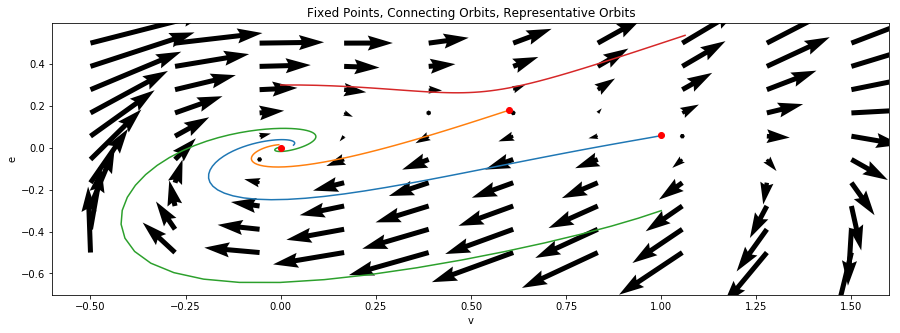

In [128]:
dv = lambda v, e: v**2 - 1.1*v + 5/3*e
de = lambda v, e: -0.5*v**3 + 1.1*v**2 - 0.66*v + v*e

α = 0.1

def solve_forward(v0, e0, n_forward=100, dist=np.inf):
    vs, es = [v0], [e0]
    v, e = v0, e0
    for i in range(n_forward):
        delta_v = dv(v, e)
        delta_e = de(v, e)
        v += α*delta_v
        e += α*delta_e
        vs.append(v)
        es.append(e)
        if np.abs(v-v0) + np.abs(e-e0) > dist:
            break
    return vs, es

def solve_backward(vn, en, n_backward=100, dist=np.inf):
    vs, es = [vn], [en]
    v, e = vn, en
    for i in range(n_backward):
        delta_v = dv(v, e)
        delta_e = de(v, e)
        v -= α*delta_v
        e -= α*delta_e
        vs.append(v)
        es.append(e)
        if np.abs(v-vn) + np.abs(e-en) > dist:
            break
    return vs, es

n_density = 10

fixed_points = np.array([
    [0, 0],
    [0.6, 0.18],
    [1, 0.06]
])

# fixed points
source = fixed_points[2]
sink = fixed_points[0]
saddle = fixed_points[1]

V = np.linspace(-0.5, 1.5, n_density)
E = np.linspace(-0.5, 0.5, n_density)
X, Y = np.meshgrid(V, E)

vs_1, es_1 = solve_forward(1, 0.059)
vs_2, es_2 = solve_forward(0.6, 0.179)
vs_3, es_3 = solve_forward(1, -0.3)
vs_4, es_4 = solve_forward(0, 0.3, n_forward=40)
vs_5, es_5 = solve_backward(0.61, 0.18, n_backward=1000)

plt.quiver(X, Y, dv(X,Y), de(X,Y))
plt.plot(vs_1, es_1)
plt.plot(vs_2, es_2)
plt.plot(vs_3, es_3)
plt.plot(vs_4, es_4)
# plt.plot(vs_5, es_5, color='purple', linewidth=3)
plt.scatter(fixed_points[:,0], fixed_points[:,1], color='red', zorder=3)
plt.xlabel("v")
plt.ylabel("e")
plt.title("Fixed Points, Connecting Orbits, Representative Orbits")
plt.show()

# print(vs_5[-1:], es_5[-1:])

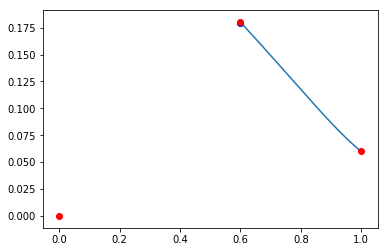

In [6]:
saddle = np.array([0.6, 0.18])
source = np.array([1, 0.06])
for i in range(1):
    saddle_hat = np.array([saddle[0] + 0.001*(np.random.rand()), saddle[1] - 0.001*np.random.rand()])
    vs, es = solve_backward(*saddle_hat, n_backward=300, dist=1)
    plt.plot(vs, es)
    plt.scatter(*saddle_hat, color='blue', zorder=2.5)

plt.scatter(fixed_points[:,0], fixed_points[:,1], color='red', zorder=3)
plt.show()

# print("v:",vs)
# print("e:",es)

[Chebyshev Collocation Equations](http://demonstrations.wolfram.com/ChebyshevCollocationMethodForLinearAndNonlinearBoundaryValue/)  
<img src="cheb_explanation.png" alt="drawing" width="1000"/>

In [3]:
np.concatenate(([2,3],[4]))

array([2, 3, 4])

C:\Users\T440\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RankWarning: The fit may be poorly conditioned


####
FSOLVE DIDN'T CONVERGE
#####
The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Max Error: 0.00000


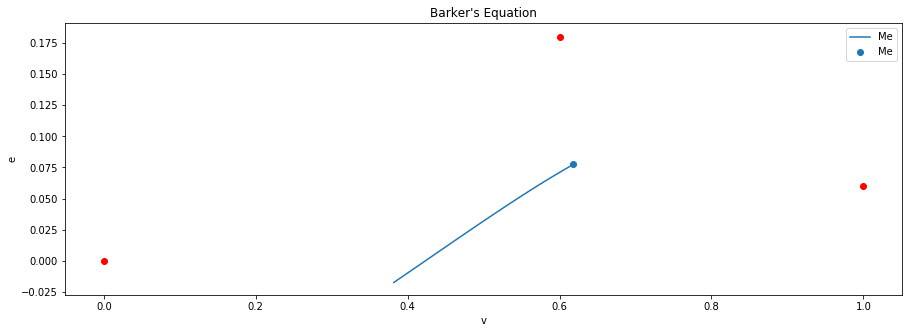

In [145]:
def my_solve_bvp(fun, bc, x, y):
    """
    See http://demonstrations.wolfram.com/ChebyshevCollocationMethodForLinearAndNonlinearBoundaryValue/
    
    Params:
    fun (function): the ODE (v', e') = f: (v,e) -> R^2.
    bc (function): same as passed into SciPy's solve_bvp.
    x ((m,) ndarray): the time mesh. Ideally Chebyshev points x[i] = cos(pi*i/N), i \in [0,N], where m = N+1.
    y ((n,m) ndarray): the initial guess. ith column refers to x[i].
    """
    # For each x[i], get u'[i] = f(x[i],u[i]), where u is an unknown. 2n equations, where n = len(x).
    # Represent u(x) = sum(a_j*T(x)) and u'(x) = sum(b_j*T(x)). Plug in the x values and we can write b_j = g(a_j).
    # So we have an equation involving only the coefficients of a_j.
    # We assume that x[i] are the Chebyshev extrema on [a,b].
    # We also have two boundary conditions, yielding 2m+2 equations.
    # So we will solve for 2m+2 coefficients, 2 sets of (m+1) coefficients, so 2 polynomials of degree m.
#     print("x:",x)
    m = x.shape[0]
#     print("m:",m)
    
    u = lambda c1, c2: np.stack((C.chebval(x=x, c=c1), C.chebval(x=x, c=c2)), axis=0)
    du = lambda c1, c2: np.stack((C.chebval(x=x, c=C.chebder(c1)), C.chebval(x=x, c=C.chebder(c2))), axis=0)
    ode = lambda c1, c2: du(c1,c2) - fun(x=x, y=u(c1,c2)) # should equal 0
        
    def fun_to_zero(c):
        c = c.reshape((2,m+1))
        c1, c2 = c[0], c[1]
        ya = np.array([C.chebval(x=x[0], c=c1), C.chebval(x=x[0], c=c2)])
        yb = np.array([C.chebval(x=x[-1], c=c1), C.chebval(x=x[-1], c=c2)])
                                  
#         print("c:",c.shape)
        ret_val = np.array([
            *ode(c1, c2).flatten(),
            *bc(ya, yb)
        ])
#         print("ret_val:",ret_val.shape)
        return ret_val
    
    c_guess = np.stack((C.chebfit(x=x, y=y[0], deg=m), C.chebfit(x=x, y=y[1], deg=m)), axis=0)
#     print("c_guess:",c_guess.shape)
    result = root(fun=fun_to_zero, x0=c_guess)
    if not result.success:
        print("####\nFSOLVE DIDN'T CONVERGE\n#####")
        print(result.message)
        print("Max Error: {:.5f}".format(np.max(result.fun)))
    c = result.x.reshape(2,m+1)
    c1, c2 = c[0], c[1]
    
#     print("c1:\n",c1)
#     print("c2:\n",c2)
#     print("u(c1,c2):\n",u(c1,c2))
#     print("u'(c1,c2):\n",du(c1,c2))
    
    poly = lambda x: np.array([C.chebval(x=x, c=c1), C.chebval(x=x, c=c2)])
    return poly
    


k = 1
def fun(x, y):
    """
    Params:
    x (m,) ndarray: the number of points to be 
    y (n,m) ndarray
    Returns:
    y' (n,m) ndarray
    """
#     return y
    assert y.shape[1] == x.shape[0], "Invalid y shape, {}".format(y.shape)
    return np.vstack((y[1], -np.exp(y[0])))

def bc(ya, yb):
#     return np.array(ya-4)
    return np.array([ya[0], yb[0]])

def fun_barker(x, y):
    v, e = y[0], y[1]
    return np.vstack((dv(v,e), de(v,e)))

def bc_barker(ya, yb):
    return np.array([
        *(ya - source + yb-sink),          # start at source
#         *(yb[0] - sink),            # finish at the sink
#         yb[1][0] + yb[1][1] * 0.33  # specify slope at sink
    ])
    return np.array([ya[0]-0.75, ya[1]])

def rescale_cheb(x_cheb, a, b):
    return ((x_cheb+1)/2)*(b-a) + a

N = 30
x_unif = np.linspace(-1, 1, N)
x_cheb = np.array([
    np.cos(i*np.pi/N)
    for i in range(N, -1, -1)
]) # Chebyshev nodes
x_cheb = rescale_cheb(x_cheb, 0, 1)

x = x_cheb

y = np.zeros((2, x.size)) # first row is y, second row is y'
y[0] = 0
y[1] = 0
# print(y)

# y = np.zeros((1, x.size))
# y[0] = 3

# sol = solve_bvp(fun_barker, bc_barker, x, y).sol(x)
my_sol = my_solve_bvp(fun_barker, bc_barker, x, y)
# print("x:",x)
# print("sol:",sol[0])
# print("my_sol:",my_sol(x))

# plt.plot(x, sol[0], label="SciPy")
# plt.plot(x, my_sol(x)[0], label="Me")
# plt.scatter(x[0], sol[0][0], color='red', zorder=3)
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title(r"$y'' + k^2y = 0$")

# plt.plot(sol[0], sol[1], label="SciPy")
# plt.scatter(sol[0][0], sol[1][0], label="SciPy")
plt.plot(my_sol(x)[0], my_sol(x)[1], label="Me")
plt.scatter(my_sol(x)[0][0], my_sol(x)[1][0], label="Me")
plt.scatter(fixed_points[:,0], fixed_points[:,1], color='red', zorder=3)
plt.xlabel("v")
plt.ylabel("e")
plt.title("Barker's Equation")
plt.legend()
plt.show()

In [94]:
y_guess = my_sol(x)
y_guess.shape

(2, 11)